# Overview
This notebook attempts to perform Exploratory Data Analysis (EDA) on the dataset: [List of Highest Grossing Concert Tours by Women](https://en.wikipedia.org/wiki/List_of_highest-grossing_concert_tours_by_women), which was scraped and made available on Kaggle as [Dirty Dataset to Practice Data Cleaning](https://www.kaggle.com/datasets/amruthayenikonda/dirty-dataset-to-practice-data-cleaning).
The dataset has 20 entries from 20 different tours and artists

In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

/tmp/ipykernel_28501/1383494717.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
sns.set_style("whitegrid")

In [4]:
df = pd.read_csv("grossing_tours.csv")

Retrieve the first 10 rows from the DataFrame

In [5]:
df.head(10)

,Rank,Peak,All Time Peak,Actual gross,Adjusted gross (in 2022 dollars),Artist,Tour title,Year(s),Shows,Average gross,Ref.
0,1,1,2,"$780,000,000","$780,000,000",Taylor Swift,The Eras Tour †,2023–2024,56,"$13,928,571",[1]
1,2,1,7[2],"$579,800,000","$579,800,000",Beyoncé,Renaissance World Tour,2023,56,"$10,353,571",[3]
2,3,1[4],2[5],"$411,000,000","$560,622,615",Madonna,Sticky & Sweet Tour ‡[4][a],2008–2009,85,"$4,835,294",[6]
3,4,2[7],10[7],"$397,300,000","$454,751,555",Pink,Beautiful Trauma World Tour,2018–2019,156,"$2,546,795",[7]
4,5,2[4],NaN,"$345,675,146","$402,844,849",Taylor Swift,Reputation Stadium Tour,2018,53,"$6,522,173",[8]
5,6,2[4],10[9],"$305,158,363","$388,978,496",Madonna,The MDNA Tour,2012,88,"$3,467,709",[9]
6,7,2[10],NaN,"$280,000,000","$381,932,682",Celine Dion,Taking Chances World Tour,2008–2009,131,"$2,137,405",[11]
7,7,NaN,NaN,"$257,600,000","$257,600,000",Pink,Summer Carnival †,2023–2024,41,"$6,282,927",[12]
8,9,NaN,NaN,"$256,084,556","$312,258,401",Beyoncé,The Formation World Tour,2016,49,"$5,226,215",[13]
9,10,NaN,NaN,"$250,400,000","$309,141,878",Taylor Swift,The 1989 World Tour,2015,85,"$2,945,882",[14]


In [6]:
df.columns

Index(['Rank', 'Peak', 'All Time Peak', 'Actual gross',
       'Adjusted gross (in 2022 dollars)', 'Artist', 'Tour title', 'Year(s)',
       'Shows', 'Average gross', 'Ref.'],
      dtype='object')

## Data Cleaning and Preprocessing

### Selecting relevant columns
The only columns we want to work with are:

 - `Rank`: Ranking of the show by gross revenue
 - `Actual gross`: The amount (in USD) generated by the tour
 - `Adjusted gross (in 2022 dollars)`: The `Actual gross` column, with inflation changes applied
 - `Artist`: The female artist/band that organized the tour
 - `Tour title`: The name of the tour, as used in campaigns and promotional material
 - `Year(s)`: The year(s) in which the tour was conducted
 - `Shows`: The number of shows within the tour
 - `Average gross`: The average gross raised from each show on average

We rename some columns so the dataframe is easier to work with and drop unnecessary columns

In [7]:
# Rename
df.rename(
    columns={
        "Rank": "rank",
        "Adjusted gross (in 2022 dollars)": "adj_gross",
        "Actual gross": "gross",
        "Artist": "artist",
        "Tour title": "tour_title",
        "Year(s)": "years",
        "Shows": "shows",
        "Average gross": "avg_gross",
    },
    inplace=True,
)

# Drop unnecessary columns
columns = [
    "rank",
    "gross",
    "adj_gross",
    "artist",
    "tour_title",
    "years",
    "shows",
    "avg_gross",
]
df = df.loc[:, columns]
df.head(10)

,rank,gross,adj_gross,artist,tour_title,years,shows,avg_gross
0,1,"$780,000,000","$780,000,000",Taylor Swift,The Eras Tour †,2023–2024,56,"$13,928,571"
1,2,"$579,800,000","$579,800,000",Beyoncé,Renaissance World Tour,2023,56,"$10,353,571"
2,3,"$411,000,000","$560,622,615",Madonna,Sticky & Sweet Tour ‡[4][a],2008–2009,85,"$4,835,294"
3,4,"$397,300,000","$454,751,555",Pink,Beautiful Trauma World Tour,2018–2019,156,"$2,546,795"
4,5,"$345,675,146","$402,844,849",Taylor Swift,Reputation Stadium Tour,2018,53,"$6,522,173"
5,6,"$305,158,363","$388,978,496",Madonna,The MDNA Tour,2012,88,"$3,467,709"
6,7,"$280,000,000","$381,932,682",Celine Dion,Taking Chances World Tour,2008–2009,131,"$2,137,405"
7,7,"$257,600,000","$257,600,000",Pink,Summer Carnival †,2023–2024,41,"$6,282,927"
8,9,"$256,084,556","$312,258,401",Beyoncé,The Formation World Tour,2016,49,"$5,226,215"
9,10,"$250,400,000","$309,141,878",Taylor Swift,The 1989 World Tour,2015,85,"$2,945,882"


Taking a look at the data types of the gross columns, we need to convert from string to numeric values.
We make use of a RegEx query to match and extract dollar values from a string. It specifically matches a dollar sign followed by a number that can include thousands separators (,), and an optional decimal part (.xx). The number can have one to three digits before the thousands separator and one or more digits after the decimal point

The RegEx query is **r"\$(\d{1,3}(?:,\d{3})*(?:\.\d+)?)"**

    - \$: Matches a literal dollar sign in the text.

    - (: Begins a capturing group.

    - \d{1,3}: Matches one to three digits.

    - (?:,\d{3})*: Non-capturing group (?: ... ) followed by * which means zero or more occurrences of a comma , followed by exactly three digits \d{3}. This matches the thousands separator in numbers like 1,000 or 1,000,000.

    - (?:\.\d+)?: Non-capturing group (?: ... ) followed by ? which means zero or one occurrence of a decimal point . followed by one or more digits \d+. This matches the decimal part of the number if present.

    - ): Ends the capturing group.


In [8]:
df["gross"]

0        $780,000,000
1        $579,800,000
2        $411,000,000
3        $397,300,000
4        $345,675,146
5        $305,158,363
6        $280,000,000
7        $257,600,000
8        $256,084,556
9        $250,400,000
10    $229,100,000[b]
11       $227,400,000
12       $204,000,000
13       $200,000,000
14       $194,000,000
15       $184,000,000
16       $170,000,000
17       $169,800,000
18    $167,700,000[e]
19       $150,000,000
Name: gross, dtype: object

In [9]:
df.dtypes

rank           int64
gross         object
adj_gross     object
artist        object
tour_title    object
years         object
shows          int64
avg_gross     object
dtype: object

In [10]:
DOLLAR_VALUE_REGEX = r"\$(\d{1,3}(?:,\d{3})*(?:\.\d+)?)"

# Converting from string to numbers
df["gross"] = (
    df["gross"]
    .str.extract(DOLLAR_VALUE_REGEX, expand=False)
    .str.replace(",", "")
    .astype(float)
)
df["adj_gross"] = (
    df["adj_gross"]
    .str.extract(DOLLAR_VALUE_REGEX, expand=False)
    .str.replace(",", "")
    .astype(float)
)
df["avg_gross"] = (
    df["avg_gross"]
    .str.extract(DOLLAR_VALUE_REGEX, expand=False)
    .str.replace(",", "")
    .astype(float)
)

We can also perform a bit of feature engineering, to create a new feature - the no. of years the tour was held for.

In [11]:
# Getting a visual of all the unique year values
df["years"].unique()

array(['2023–2024', '2023', '2008–2009', '2018–2019', '2018', '2012',
       '2016', '2015', '2013–2014', '2009–2011', '2014–2015', '2002–2005',
       '2006', '2012–2013', '2015–2016', '2016–2017'], dtype=object)

In [12]:
def calc_no_years(x):
    years = x.split("–")

    if len(years) == 2:
        oldest, latest = years
        oldest, latest = int(oldest), int(latest)
        return latest - oldest

    return 1


df["no_years"] = df["years"].apply(calc_no_years)

In [13]:
df["no_years"].unique()

array([1, 2, 3])

Our dateset finally looks like:

In [14]:
df.sample(5)

,rank,gross,adj_gross,artist,tour_title,years,shows,avg_gross,no_years
3,4,397300000.0,454751555.0,Pink,Beautiful Trauma World Tour,2018–2019,156,2546795.0,1
4,5,345675146.0,402844849.0,Taylor Swift,Reputation Stadium Tour,2018,53,6522173.0,1
14,15,194000000.0,281617035.0,Madonna,Confessions Tour,2006,60,3233333.0,1
7,7,257600000.0,257600000.0,Pink,Summer Carnival †,2023–2024,41,6282927.0,1
6,7,280000000.0,381932682.0,Celine Dion,Taking Chances World Tour,2008–2009,131,2137405.0,1


## Exploratory Data Analysis

In [15]:
df.describe()

,rank,gross,adj_gross,shows,avg_gross,no_years
count,20.000000,2.000000e+01,2.000000e+01,20.000000,2.000000e+01,20.00000
mean,10.450000,2.879509e+08,3.438781e+08,110.000000,3.726571e+06,1.15000
std,5.942488,1.563284e+08,1.514627e+08,66.507617,3.393340e+06,0.48936
min,1.000000,1.500000e+08,1.854231e+08,41.000000,6.153850e+05,1.00000
25%,5.750000,1.915000e+08,2.457557e+08,59.000000,1.647508e+06,1.00000
50%,10.500000,2.397500e+08,2.974889e+08,87.000000,2.342100e+06,1.00000
75%,15.250000,3.152876e+08,3.924451e+08,134.500000,4.933024e+06,1.00000
max,20.000000,7.800000e+08,7.800000e+08,325.000000,1.392857e+07,3.00000


Using `describe`, we see that:
 - There are 20 rows in the dataset
 - The average (mean) adjusted gross of a tour is approx. *\$ 340 million*  with a standard deviation of *\$ 160 million*
 - Interestingly, the average tour had a *110* shows, with each show netting an average of *\$ 4 million*.
 - On average, most tours run for a year.

In [16]:
df.isna().any()

rank          False
gross         False
adj_gross     False
artist        False
tour_title    False
years         False
shows         False
avg_gross     False
no_years      False
dtype: bool

Checking for missing (NaN) values, we see that our selected columns have no missing values.

We can proceed with our analysis

In [17]:
categorical_cols = [
    "artist",
    "tour_title",
]
numeric_cols = ["rank", "gross", "adj_gross", "shows", "no_years"]

In [18]:
df[numeric_cols].cov()

,rank,gross,adj_gross,shows,no_years
rank,3.531316e+01,-7.684764e+08,-7.768592e+08,1.094211e+02,4.552632e-01
gross,-7.684764e+08,2.443858e+16,2.301495e+16,-3.180538e+09,-1.244488e+07
adj_gross,-7.768592e+08,2.301495e+16,2.294094e+16,-2.288910e+09,-7.209488e+06
shows,1.094211e+02,-3.180538e+09,-2.288910e+09,4.423263e+03,2.752632e+01
no_years,4.552632e-01,-1.244488e+07,-7.209488e+06,2.752632e+01,2.394737e-01


Considering the covariance of the distribution, we find that:

 - _Rank_: It has positive covariance with 'shows' (1.094211e+02) and 'no_years' (4.552632e-01), indicating that as the 'rank' increases, 'shows' and 'no_years' tend to increase as well.

 - _Gross_: It has negative covariance with 'rank' (-7.684764e+08), 'adj_gross' (2.301495e+16), and 'shows' (-3.180538e+09), indicating that as 'gross' increases, 'rank', 'adj_gross', and 'shows' tend to decrease.

 - _Adj_gross_: Variance of the 'adj_gross' variable is 2.294094e+16. It has negative covariance with 'rank' (-7.768592e+08), 'gross' (2.301495e+16), and 'shows' (-2.288910e+09), indicating similar behavior to 'gross'.

 - _Shows_: Variance of the 'shows' variable is 4.423263e+03. It has positive covariance with 'rank' (1.094211e+02) and negative covariance with 'gross' (-3.180538e+09) and 'adj_gross' (-2.288910e+09).

 - _No_years_: Variance of the 'no_years' variable is 2.394737e-01. It has positive covariance with 'rank' (4.552632e-01), indicating that as 'no_years' increases, 'rank' tends to increase as well.

In [19]:
df[numeric_cols].corr()

,rank,gross,adj_gross,shows,no_years
rank,1.000000,-0.827226,-0.863114,0.276861,0.156554
gross,-0.827226,1.000000,0.972000,-0.305908,-0.162676
adj_gross,-0.863114,0.972000,1.000000,-0.227223,-0.097268
shows,0.276861,-0.305908,-0.227223,1.000000,0.845761
no_years,0.156554,-0.162676,-0.097268,0.845761,1.000000


Considering the correlation of the distribution:

> (which closely mirrors the results of `cov` since they are built on similar principles)

The correlation coefficients represent the strength and direction of linear relationships between pairs of variables:

- A value close to 1 indicates a strong positive correlation.
- A value close to -1 indicates a strong negative correlation.
- A value close to 0 indicates a weak or no correlation.

Specifically:

- Rank and Gross/Adjusted Gross: Strong negative correlation, meaning higher ranks correspond to lower gross earnings.
- Gross and Adjusted Gross: Very strong positive correlation, indicating a high similarity between these variables.
- Shows and No Years: Strong positive correlation, suggesting more shows are associated with more years of experience.
- Other correlations are weak or negligible.

We can visualize the correlation of the datasets features in a heatmap viz:

Text(0.5, 1.0, 'Heatmap of the Correlation of Features')

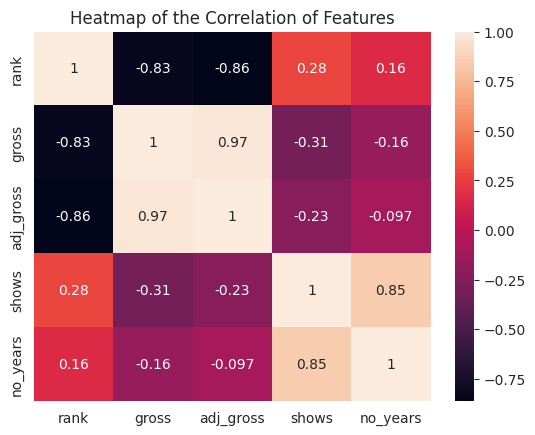

In [20]:
sns.heatmap(df[numeric_cols].corr(), annot=True)
plt.title("Heatmap of the Correlation of Features")

In [21]:
df[numeric_cols].kurtosis()

rank         -1.234607
gross         4.631258
adj_gross     2.452200
shows         4.925807
no_years     11.885038
dtype: float64

This reveals that:

- _Rank_: We can ignore this value since it is simply the ranking of tours by gross. For consistency, it is platykurtic, and flatter than a normal distribution.
- _Gross_, _Adjusted Gross_, _Shows_: These distributions are leptokurtic, and more peaked with heavier tails than a normal distribution.
- _No_years_: The distribution is strongly leptokurtic, and highly peaked with very heavy tails compared to a normal distribution.

### Data Visualization

In [22]:
# Define custom formatting function
def dollar_formatter(x, pos):
    """
    Custom formatting function to display dollar values.
    """
    return "${:,.0f}".format(x)

In [23]:
def plot_bar():
    """
    A function to plot a bar chart of categories `x`, having frequency `y`.
    It plots a stacked bar chart of artists and the gross generated from their tours.

    :returns: 'Touring Gross by Artist' figure
    :rtype: matplotlib.axes.Axes
    """
    # Increase the size of the figure
    plt.figure(figsize=(20, 5))

    plt.xlabel("$Artist$")
    plt.ylabel("$Adjusted Gross$")
    plt.title("Touring Gross by Artist")
    formatter = FuncFormatter(dollar_formatter)
    plt.gca().yaxis.set_major_formatter(formatter)
    return sns.barplot(
        x=df["artist"],
        y=df["adj_gross"],
        hue=df["tour_title"],
        dodge=False,
        legend=False,
    )

**Some artists have multiple tours in the dataset. Who has the highest gross revenue overall in the dataset?**

We can visualize the gross revenue generated by each artist with a stacked bar chart, viz:

<Axes: title={'center': 'Touring Gross by Artist'}, xlabel='$Artist$', ylabel='$Adjusted Gross$'>

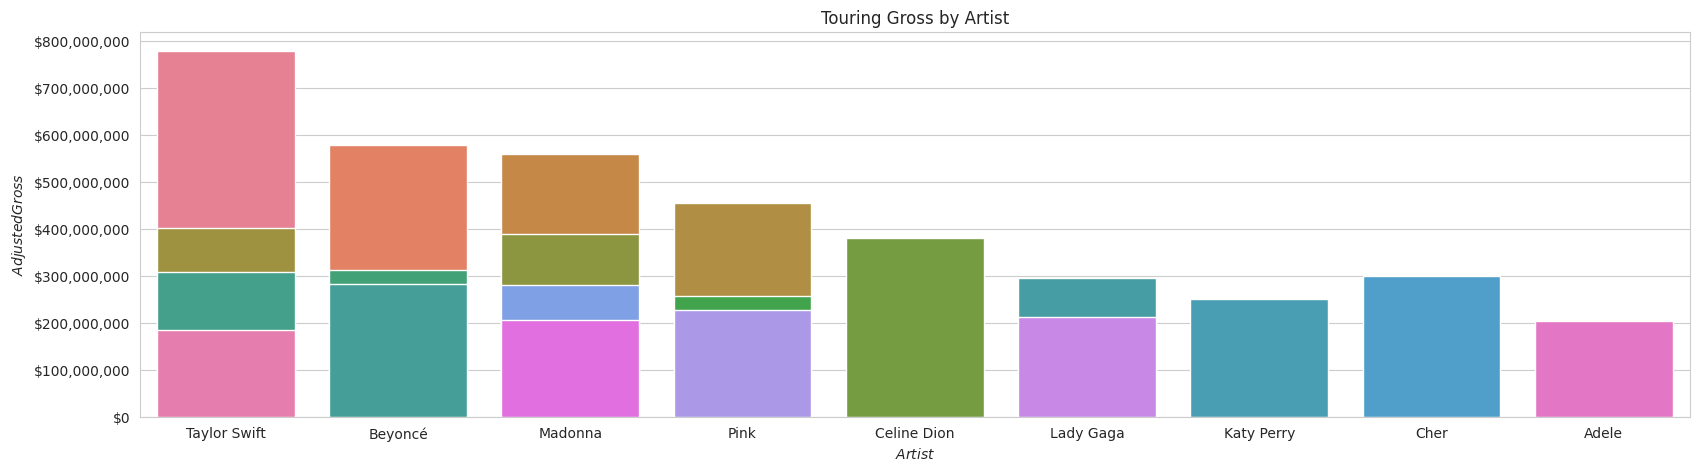

In [32]:
plot_bar()

In [25]:
def plot_gross_hist():
    """
    Plot a histogram of adjusted gross.

    This function creates a histogram of the adjusted gross using Seaborn's histplot function.
    Adjusted gross values are plotted along the x-axis, and the count of occurrences is plotted
    along the y-axis. A kernel density estimation (KDE) curve is also included.
    """
    plt.figure(figsize=(20, 5))
    sns.histplot(data=df, x="adj_gross", kde=True)
    plt.title("Distribution of Adjusted Gross")
    plt.xlabel("$Adjusted Gross$")
    plt.ylabel("$Count$")
    formatter = FuncFormatter(dollar_formatter)
    plt.gca().xaxis.set_major_formatter(formatter)

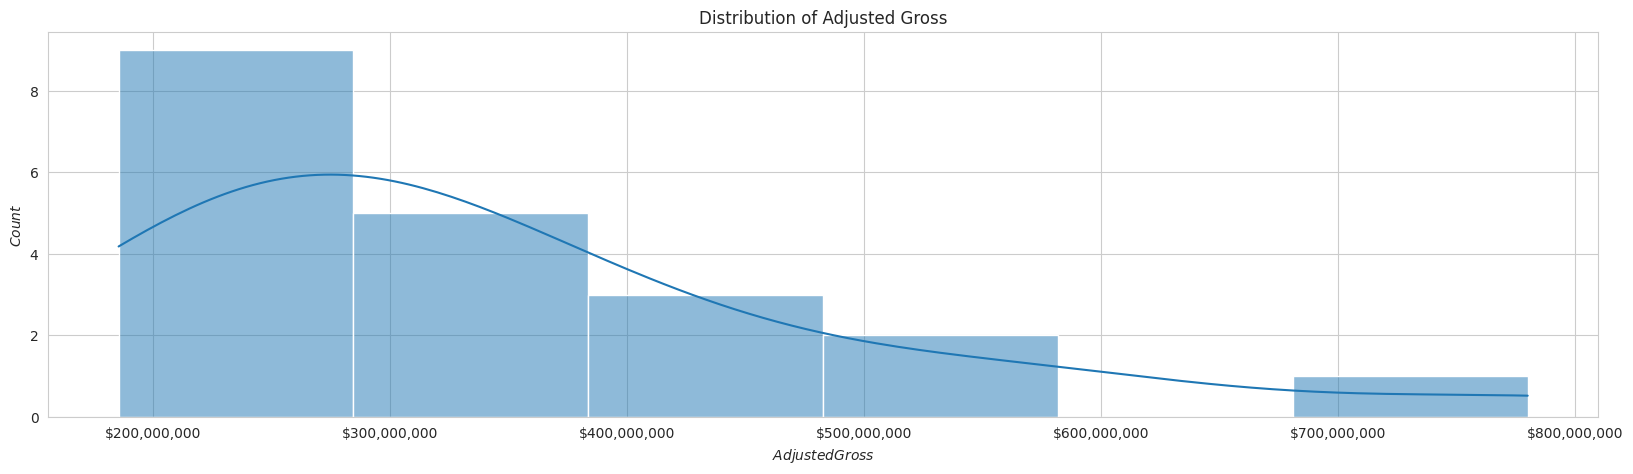

In [26]:
plot_gross_hist()

_Adj. gross_ is right-skewed, and from the histogram, it is evident that most tours grossed between 200- 300 million ( _USD_ )

In [30]:
def plot_lines():
    """
    Plot line plots of gross and adjusted gross against number of shows.

    This function creates line plots of both gross and adjusted gross against the number of shows
    using Seaborn's scatterplot and lineplot functions. Two scatter plots and two line plots are
    created for both gross and adjusted gross. The x-axis represents the number of shows, and the
    y-axis represents the respective gross values.


    :param None: This function does not take any parameters.
    :returns: None
    :rtype: None
    """
    fig = plt.figure(figsize=(20, 5))
    sns.scatterplot(data=df, x="shows", y="adj_gross", label="Adjusted Gross")
    line_adj_gross = sns.lineplot(data=df, x="shows", y="adj_gross")
    sns.scatterplot(data=df, x="shows", y="gross", label="Original Gross")
    line_gross = sns.lineplot(data=df, x="shows", y="gross")
    plt.title("Line Plot of $Gross$ & $Adj. Gross$ against $No. Shows$")
    plt.xlabel("No. of Shows")
    plt.ylabel("Gross")
    formatter = FuncFormatter(dollar_formatter)
    plt.gca().yaxis.set_major_formatter(formatter)

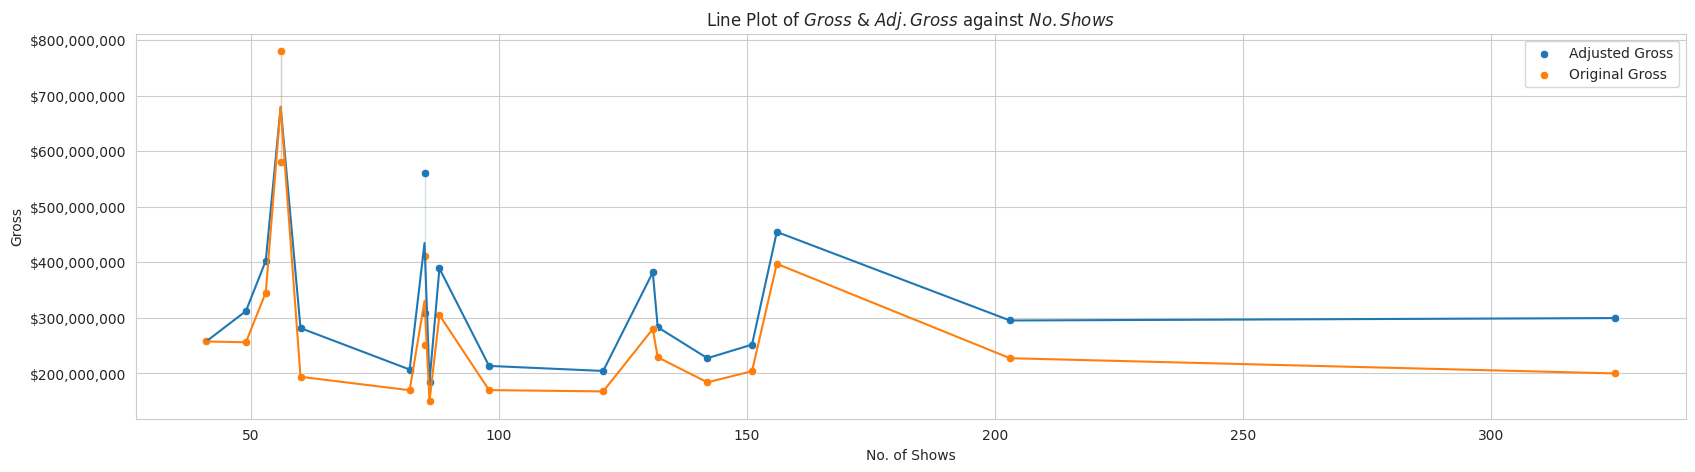

In [31]:
plot_lines()

**Will having more shows increase a tour's gross revenue?**

From our plots and analyis, the answer is no. There is no simple linear relationship between `no_shows` and `adj_gross`. On the contrary, a correlation score of _-0.23_ suggests a negative relationship, albeit statistically insignificant.

<Axes: title={'center': 'Violin Plot of Artists and their Touring Gross'}, xlabel='artist', ylabel='adj_gross'>

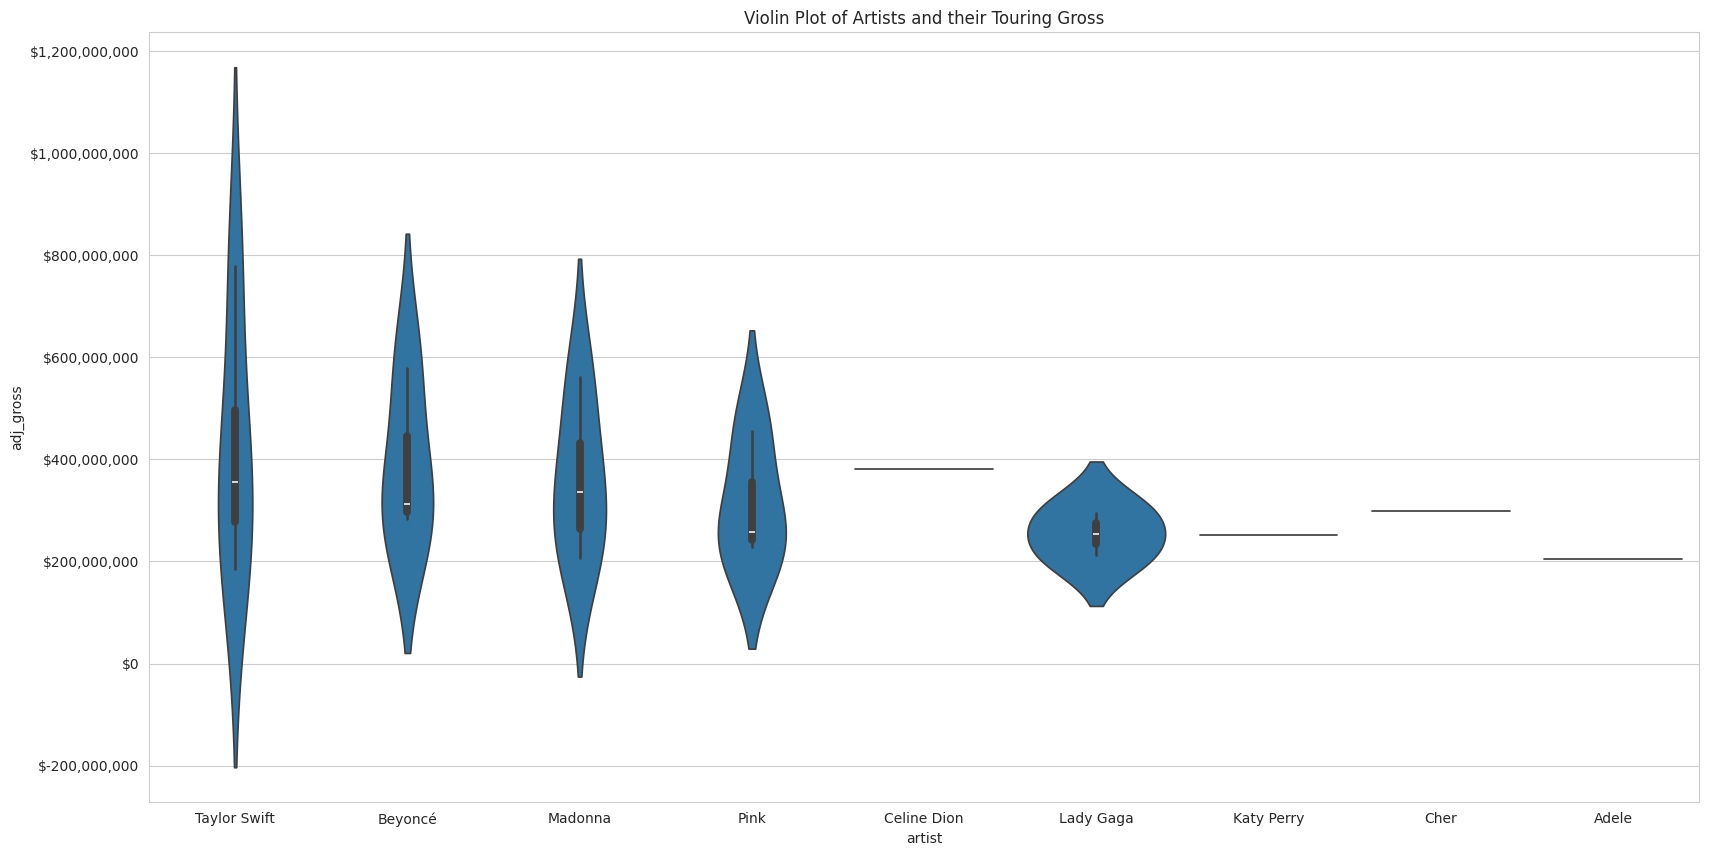

In [29]:
plt.figure(figsize=(20, 10))
formatter = FuncFormatter(dollar_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title("Violin Plot of Artists and their Touring Gross")
sns.violinplot(
    data=df,
    x="artist",
    y="adj_gross",
)